In [26]:
import numpy as np
from tqdm import tqdm_notebook
from sklearn.metrics import log_loss,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import matplotlib.colors
from sklearn.datasets import load_iris
from numpy.linalg import norm
import warnings
warnings.filterwarnings="ignore"

#  Sample Data

In [2]:
iris = load_iris()
data = iris.data
labels = iris.target
print(data.shape,labels.shape)

(150, 4) (150,)


# Train-Test-Split

In [3]:
X_train,X_val,Y_train,Y_val = train_test_split(data,labels,stratify=labels,random_state=0,test_size = 0.2)
print(X_train.shape,Y_train.shape,X_val.shape,Y_val.shape)

(120, 4) (120,) (30, 4) (30,)


# One hot encoding of Y_train

In [4]:
enc = OneHotEncoder()
Y_train_one_hot = enc.fit_transform(np.expand_dims(Y_train,1)).toarray()
print(Y_train_one_hot.shape)

(120, 3)


# Multi-Layer-Perceptron/Feed Forward Nueral Network Class
## With optimizers : Momentum , AdaGrad, RMSProp, Adam

In [5]:
class Nueral_Network:

    def __init__(self,hidden_layer=[4,8,8,3],num_nu1 = 8,num_nu2 = 8,output_layer=4,num_layers = 3,init_algo = 'random',activation='sigmoid'):
        np.random.seed(0)
        self.activation = activation
        self.params = {}
        self.hidden_layer = [4,num_nu1,num_nu2,3]
        self.leaky_slope = 0.1
        self.update_params = {}
        self.gradients = {}
        self.num_layers = num_layers
        

#     parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
#                     W1 -- weight matrix of shape (layers_dims[1], layers_dims[0])
#                     b1 -- bias vector of shape (layers_dims[1], 1)
#                     ...
#                     WL -- weight matrix of shape (layers_dims[L], layers_dims[L-1])
#                     bL -- bias vector of shape (layers_dims[L], 1)

# W1: The number of rows is the number of hidden units of that layer, dims[1], 
#     and the number of columns is the number of features/rows of the previous layer (in this case X, our input data), dims[0].
# b1: Same number of rows as W1 and a single column.
        
        if(init_algo == 'random'):
            for i in range(1,num_layers + 1):
                self.params['W' + str(i)] = np.random.randn(self.hidden_layer[i-1],self.hidden_layer[i])
                self.params['B' + str(i)] = np.random.randn(1,self.hidden_layer[i])
        elif(init_algo == 'zero'):
            for i in range(1,num_layers + 1):
                self.params['W' + str(i)] = np.zeros((self.hidden_layer[i-1],self.hidden_layer[i]))
                self.params['B' + str(i)] = np.zeros((1,self.hidden_layer[i]))
        elif(init_algo == 'xavier'):
            for i in range(1,num_layers + 1):
                self.params['W' + str(i)] = np.random.randn(self.hidden_layer[i-1],self.hidden_layer[i])*np.sqrt(1/self.hidden_layer[i-1])
                self.params['B' + str(i)] = np.random.randn(1,self.hidden_layer[i])
                
        elif(init_algo == 'he'):
            for i in range(1,num_layers + 1):
                self.params['W' + str(i)] = np.random.randn(self.hidden_layer[i-1],self.hidden_layer[i])*np.sqrt(2/self.hidden_layer[i-1])
                self.params['B' + str(i)] = np.random.randn(1,self.hidden_layer[i])
                
        print("parameters: ",self.params)
            
        for i in range(1,num_layers+1):
            self.update_params['v_w' + str(i)] = 0
            self.update_params['v_b' + str(i)] = 0
            self.update_params['m_w' + str(i)] = 0
            self.update_params['m_b' + str(i)] = 0
            
        print("update_params :",self.update_params)
            
    
    def forward_activation(self,X):
        
        if(self.activation == 'sigmoid'):
            return(1.0/(1.0 + np.exp(-X)))
        elif(self.activation == 'tanh'):
            return(np.tanh(X))
        elif(self.activation == 'relu'):
            return(np.maximum(0,X))
        elif(self.activation == 'leaky relu'):
            return(np.maximum(self.leaky_slope * X,X))
    
    def grad_activation(self,X):
        if(self.activation == 'sigmoid'):
            return(X * (1-X))
        elif(self.activation == 'tanh'):
            return(1-np.square(X))
        elif(self.activation == 'relu'):
            return(1.0 * (X>0))

        elif(self.activation == 'leaky relu'):
            d = np.zeros_like(X)
            d[X<=0] = self.leaky_slope
            d[X>0] = 1.0
            return d
            
    
    def softmax(self,X):
        exps = np.exp(X) # (N,2)
        sums_exp = np.sum(exps,axis=1).reshape(-1,1) #(N,1)
        return(exps/sums_exp) #(N,2) / (N,1) --> (N,2)
        
    
    def forward_pass(self,X):
        
        # Layer 1(Hidden)
        self.params['A1'] = np.matmul(X,self.params['W1']) + self.params['B1'] #(N,4) * (4,8)-->(N,8) + (N,8)
        self.params['H1'] = self.forward_activation(self.params['A1']) # (N,8)
        
        #Layer 2(Hidden)
        self.params['A2'] = np.matmul(self.params['H1'],self.params['W2']) + self.params['B2'] #(N,8) * (8,8)-->(N,8)
        self.params['H2'] = self.forward_activation(self.params['A2']) #(N,8)
        
        #Layer 3(Output)
        self.params['A3'] = np.matmul(self.params['H2'],self.params['W3']) + self.params['B3'] #(N,8) * (8,3)-->(N,3)
        self.params['H3'] = self.softmax(self.params['A3']) #(N,3)
        
        # print("parameters of layers : ",self.params)
        
        return(self.params['H3']) #(N,3)
    
    
    def grad(self,X,Y):
        
        self.forward_pass(X)
        
        #Layer 3
        self.gradients['dA3'] = self.params['H3'] - Y #(N,3) - (N,3) -->(N,3)
        self.gradients['dW3'] = np.matmul(self.params['H2'].T,self.gradients['dA3']) # (8,N) * (N,3) -->(8,3)
        self.gradients['dB3'] = np.sum(self.gradients['dA3'],axis=0).reshape(1,-1) 
        
        #Layer 2 
        self.gradients['dH2'] = np.matmul(self.gradients['dA3'],self.params['W3'].T) #(N,3) * (3,8) -- >(N,8)
        self.gradients['dA2'] = np.multiply(self.gradients['dH2'],self.grad_activation(self.params['H2'])) #(N,8) * (N,8)-->(N,8)
        self.gradients['dW2'] = np.matmul(self.params['H1'].T,self.gradients['dA2']) #(8,N) * (N,8)   --> (8,8)
        self.gradients['dB2'] = np.sum(self.gradients['dA2'],axis=0).reshape(1,-1)
        
        #Layer 1
        self.gradients['dH1'] = np.matmul(self.gradients['dA2'],self.params['W2'].T) #(N,8) * (8,8) -->(N,8)
        self.gradients['dA1'] = np.multiply(self.gradients['dH1'],self.grad_activation(self.params['H1'])) #(N,8) * (N,8)
        self.gradients['dW1'] = np.matmul(X.T,self.gradients['dA1']) #(4,N) * (N,8) -->(4,8)
        self.gradients['dB1'] = np.sum(self.gradients['dA1'],axis=0).reshape(1,-1)
        
        # print("gradients: ",self.gradients)
    
    def get_accuracy(self):
        
        Y_pred_train = self.predict(X_train)
        Y_pred_train = np.argmax(Y_pred_train,axis=1)
        Y_pred_val = self.predict(X_val)
        Y_pred_val = np.argmax(Y_pred_val,axis=1)
        
        train_accuracy = accuracy_score(Y_pred_train,Y_train)
        val_accuracy = accuracy_score(Y_pred_val,Y_val)
        
        return train_accuracy,val_accuracy
        
    def fit(self,X,Y,l2_norm=False,lambda_val=0.8,epochs=1,eta=1,display_loss = False,algo='GD',gamma=0.8,eps = 1e-8,beta = 0.8,beta1=0.8,beta2=0.8):
        
        if(display_loss):
            training_loss = {}
            training_acc = {}
            val_acc = {}
            weight_mag = {}
        
        for epoch in tqdm_notebook(range(epochs),unit="epoch",total=epochs):
            
            if(algo == 'GD'):
            
                self.grad(X,Y)

                m = X.shape[0]
                for i in range(1,self.num_layers+1):
                    
                    
                    if(l2_norm):
                        self.params['W' + str(i)] -= (eta * lambda_val)/m * self.params['W' + str(i)] + eta * (self.gradients['dW' + str(i)]/m)
                    else:
                        self.params['W' + str(i)] -= eta * (self.gradients['dW' + str(i)]/m)
                    self.params['B' + str(i)] -= eta * (self.gradients['dB'+ str(i)]/m)
                

                Y_pred = self.predict(X)
                training_loss[epoch] = log_loss(np.argmax(Y,axis=1),Y_pred)
                train,val = self.get_accuracy()
                training_acc[epoch] = train
                val_acc[epoch] = val
                weight_mag[epoch] = (norm(self.params['W1']) + norm(self.params['W2']) + norm(self.params['W3']) + norm(self.params['B1']) + norm(self.params['B2']) + norm(self.params['B3']))/18
                
            
            elif(algo == 'Momentum'):
                self.grad(X,Y)
                m = X.shape[0]
                
                for i in range(1,self.num_layers+1):
                
                    self.update_params['v_w' + str(i)] = gamma*self.update_params['v_w' + str(i)] + eta * (self.gradients['dW' + str(i)])/m
                    self.update_params['v_b' + str(i)] = gamma*self.update_params['v_b' + str(i)] + eta * (self.gradients['dB' + str(i)])/m
                    self.params['W' + str(i)] -= self.update_params['v_w' + str(i)]
                    self.params['B' + str(i)] -= self.update_params['v_b' + str(i)]
                
                Y_pred = self.predict(X)
                training_loss[epoch] = log_loss(np.argmax(Y,axis=1),Y_pred)
                
            
            elif(algo == 'AdaGrad'):
                self.grad(X,Y)
                m = X.shape[0]
                
                for i in range(1,self.num_layers+1):
                    
                    self.update_params['v_w' + str(i)] = self.update_params['v_w' + str(i)] + ((self.gradients['dW' + str(i)]/m) ** 2)
                    self.update_params['v_b' + str(i)] = self.update_params['v_b' + str(i)] + ((self.gradients['dB' + str(i)]/m) ** 2)
                    self.params['W' + str(i)] -= (eta/np.sqrt(self.update_params['v_w' + str(i)]+eps)) * self.gradients['dW' + str(i)]/m
                    self.params['B' + str(i)] -= (eta/np.sqrt(self.update_params['v_b' + str(i)]+eps)) * self.gradients['dB' + str(i)]/m
                
                Y_pred = self.predict(X)
                loss[epoch] = log_loss(np.argmax(Y,axis=1),Y_pred)
            
            elif(algo == 'RMSProp'):
                self.grad(X,Y)
                m = X.shape[0]
                
                for i in range(1,self.num_layers+1):
                    
                    self.update_params['v_w' + str(i)] = beta*self.update_params['v_w' + str(i)] + (1-beta)*((self.gradients['dW' + str(i)]/m) ** 2)
                    self.update_params['v_b' + str(i)] = beta*self.update_params['v_b' + str(i)] + (1-beta)*((self.gradients['dB' + str(i)]/m) ** 2)
                    self.params['W' + str(i)] -= (eta/np.sqrt(self.update_params['v_w' + str(i)]+eps)) * self.gradients['dW' + str(i)]/m
                    self.params['B' + str(i)] -= (eta/np.sqrt(self.update_params['v_b' + str(i)]+eps)) * self.gradients['dB' + str(i)]/m
                    
                Y_pred = self.predict(X)
                loss[epoch] = log_loss(np.argmax(Y,axis=1),Y_pred)
            
            elif(algo == 'Adam'):
                self.grad(X,Y)
                m = X.shape[0]
                num_updates = 0
                for i in range(1,self.num_layers+1):
                    num_updates+=1

                    self.update_params['m_w' + str(i)] = beta1*self.update_params['m_w' + str(i)] + ((1-beta1) * self.gradients['dW' + str(i)]/m) 
                    self.update_params['m_b' + str(i)] = beta1*self.update_params['m_b' + str(i)] + ((1-beta1) * self.gradients['dB' + str(i)]/m) 
                    self.update_params['v_w' + str(i)] = beta2*self.update_params['v_w' + str(i)] + ((1-beta2) * ((self.gradients['dW' + str(i)]/m)**2))
                    self.update_params['v_b' + str(i)] = beta2*self.update_params['v_b' + str(i)] + ((1-beta2) * ((self.gradients['dB' + str(i)]/m)**2))
                    m_w_hat=self.update_params["m_w"+str(i)]/(1-np.power(beta1,num_updates))
                    v_w_hat=self.update_params["v_w"+str(i)]/(1-np.power(beta2,num_updates))
                    m_b_hat=self.update_params["m_b"+str(i)]/(1-np.power(beta1,num_updates))
                    v_b_hat=self.update_params["v_b"+str(i)]/(1-np.power(beta2,num_updates))

                    self.params['W' + str(i)] -= (eta/np.sqrt(v_w_hat + eps))* m_w_hat
                    self.params['B' + str(i)] -= (eta/np.sqrt(v_b_hat + eps))* m_b_hat
                
                Y_pred = self.predict(X)
                loss[epoch] = log_loss(np.argmax(Y,axis=1),Y_pred)
                    
                

        if(display_loss):
            fig,ax1 = plt.subplots()
            
            ax1.plot(list(training_loss.values()),label='Loss')
            ax1.set_title('Loss Plot')
            ax1.set_xlabel('Epochs')
            ax1.set_ylabel('Log Loss')
            ax2 = ax1.twinx()
            ax2.set_ylabel('Weight Magnitude')
            ax2.plot(list(weight_mag.values()),color='r',label='Weight Magnitude')
            plt.legend()
            plt.show()
            
        if(display_loss):
            plt.figure()
            plt.plot(list(training_acc.values()),label='Training Loss',color='blue')
            plt.plot(list(val_acc.values()),label='Validation Loss',color='green')
            plt.plot(np.ones((epochs,1))*0.9,label='High Standard',color='red')
            plt.plot(np.ones((epochs,1))*0.33,label='Lowest Standard',color='violet')
            plt.title('Accuracy Plot')
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            plt.legend(loc='upper right')
            plt.show()
    
    def predict(self,X):
        Y_pred = []
        return(np.asarray(self.forward_pass(X))) #(N,2)
    

In [6]:
def print_accuracy():
    Y_pred_train = mlp.predict(X_train)
#     print(Y_pred_train)
    Y_pred_train = np.argmax(Y_pred_train,axis=1)
#     print(Y_pred_train)
    Y_pred_val = mlp.predict(X_val)
    Y_pred_val = np.argmax(Y_pred_val,axis=1)
    
    training_accuracy = accuracy_score(Y_train,Y_pred_train)
    validation_accuracy = accuracy_score(Y_val,Y_pred_val)
    
    print(f'The training accuracy is: {np.round(training_accuracy*100,4)}')
    print(f'The validation accuracy is: {np.round(validation_accuracy*100,4)}')

# Model Running

parameters:  {'W1': array([[ 0.88202617,  0.2000786 ,  0.48936899,  1.1204466 ,  0.933779  ,
        -0.48863894,  0.47504421, -0.0756786 ],
       [-0.05160943,  0.20529925,  0.07202179,  0.72713675,  0.38051886,
         0.06083751,  0.22193162,  0.16683716],
       [ 0.74703954, -0.10257913,  0.15653385, -0.42704787, -1.27649491,
         0.3268093 ,  0.4322181 , -0.37108251],
       [ 1.13487731, -0.72718284,  0.02287926, -0.09359193,  0.76638961,
         0.73467938,  0.07747371,  0.18908126]]), 'B1': array([[-0.88778575, -1.98079647, -0.34791215,  0.15634897,  1.23029068,
         1.20237985, -0.38732682, -0.30230275]]), 'W2': array([[-0.37071946, -0.50205216, -0.60325761,  0.68970326, -0.18018926,
        -0.15488265, -0.44293005,  0.27488435],
       [-0.57059906, -0.07521505, -0.31659524,  0.13679069, -0.18059689,
        -0.41741651, -0.00996392,  0.15143819],
       [ 0.02351739,  0.10693997, -0.22426673, -0.12824837, -0.23775067,
        -0.12712124, -0.28749063, -0.6103330

<ipython-input-5-d46152a1b57e>:148: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs),unit="epoch",total=epochs):


  0%|          | 0/380 [00:00<?, ?epoch/s]

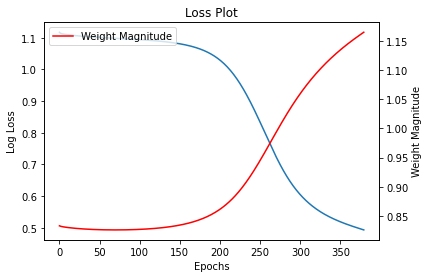

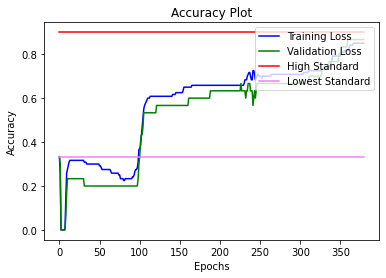

The training accuracy is: 85.0
The validation accuracy is: 86.6667


In [7]:
mlp = Nueral_Network(init_algo='xavier',activation='sigmoid')
mlp.fit(X_train,Y_train_one_hot,display_loss=True,epochs=380,eta=0.25,beta=0.8,algo='GD')
print_accuracy()

In [8]:
from sklearn.metrics import log_loss,accuracy_score
Y_pred = mlp.predict(X_train)
Y_pred_bin = np.argmax(Y_pred,axis=1)
Y_pred_bin.shape

accuracy_train = accuracy_score(Y_train.reshape(-1,1),Y_pred_bin)
print(f'The training accuracy obtained is:{accuracy_train*100}')

The training accuracy obtained is:85.0


In [9]:
Y_pred = mlp.predict(X_val)
Y_pred_bin_test = np.argmax(Y_pred,axis=1)

#print(Y_pred_bin_test.shape)

accuracy_test = accuracy_score(Y_val.reshape(-1,1),Y_pred_bin_test)
print(f'The validation accuracy obtained is:{accuracy_test*100}')

The validation accuracy obtained is:86.66666666666667


# Xavier Init with Sigmoid Activation with Regularization
###  When Lambda_val (regularization param) = 10. More weightage is given to Weight minimizing so our model does not learn anything.
### lambda_val = 1. It learns

parameters:  {'W1': array([[ 0.88202617,  0.2000786 ,  0.48936899,  1.1204466 ,  0.933779  ,
        -0.48863894,  0.47504421, -0.0756786 ],
       [-0.05160943,  0.20529925,  0.07202179,  0.72713675,  0.38051886,
         0.06083751,  0.22193162,  0.16683716],
       [ 0.74703954, -0.10257913,  0.15653385, -0.42704787, -1.27649491,
         0.3268093 ,  0.4322181 , -0.37108251],
       [ 1.13487731, -0.72718284,  0.02287926, -0.09359193,  0.76638961,
         0.73467938,  0.07747371,  0.18908126]]), 'B1': array([[-0.88778575, -1.98079647, -0.34791215,  0.15634897,  1.23029068,
         1.20237985, -0.38732682, -0.30230275]]), 'W2': array([[-0.37071946, -0.50205216, -0.60325761,  0.68970326, -0.18018926,
        -0.15488265, -0.44293005,  0.27488435],
       [-0.57059906, -0.07521505, -0.31659524,  0.13679069, -0.18059689,
        -0.41741651, -0.00996392,  0.15143819],
       [ 0.02351739,  0.10693997, -0.22426673, -0.12824837, -0.23775067,
        -0.12712124, -0.28749063, -0.6103330

<ipython-input-5-d46152a1b57e>:148: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs),unit="epoch",total=epochs):


  0%|          | 0/500 [00:00<?, ?epoch/s]

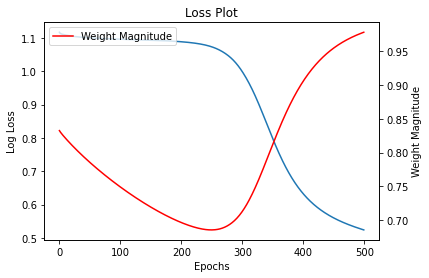

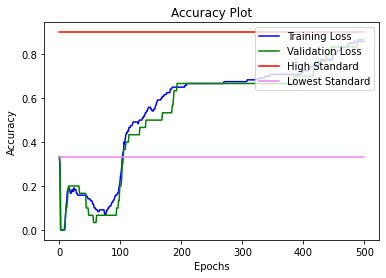

The training accuracy is: 85.8333
The validation accuracy is: 86.6667


In [10]:
mlp = Nueral_Network(init_algo='xavier',activation='sigmoid')
mlp.fit(X_train,Y_train_one_hot,display_loss=True,epochs=500,eta=0.25,beta=0.8,algo='GD',l2_norm=True,lambda_val = 1)
print_accuracy()

# Xavier with Tanh activation.

parameters:  {'W1': array([[ 0.88202617,  0.2000786 ,  0.48936899,  1.1204466 ,  0.933779  ,
        -0.48863894,  0.47504421, -0.0756786 ],
       [-0.05160943,  0.20529925,  0.07202179,  0.72713675,  0.38051886,
         0.06083751,  0.22193162,  0.16683716],
       [ 0.74703954, -0.10257913,  0.15653385, -0.42704787, -1.27649491,
         0.3268093 ,  0.4322181 , -0.37108251],
       [ 1.13487731, -0.72718284,  0.02287926, -0.09359193,  0.76638961,
         0.73467938,  0.07747371,  0.18908126]]), 'B1': array([[-0.88778575, -1.98079647, -0.34791215,  0.15634897,  1.23029068,
         1.20237985, -0.38732682, -0.30230275]]), 'W2': array([[-0.37071946, -0.50205216, -0.60325761,  0.68970326, -0.18018926,
        -0.15488265, -0.44293005,  0.27488435],
       [-0.57059906, -0.07521505, -0.31659524,  0.13679069, -0.18059689,
        -0.41741651, -0.00996392,  0.15143819],
       [ 0.02351739,  0.10693997, -0.22426673, -0.12824837, -0.23775067,
        -0.12712124, -0.28749063, -0.6103330

<ipython-input-5-d46152a1b57e>:148: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs),unit="epoch",total=epochs):


  0%|          | 0/500 [00:00<?, ?epoch/s]

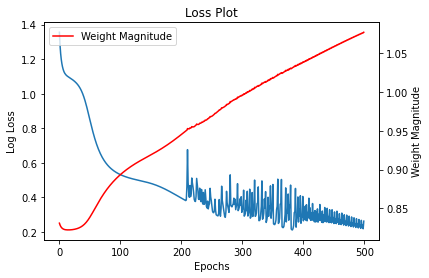

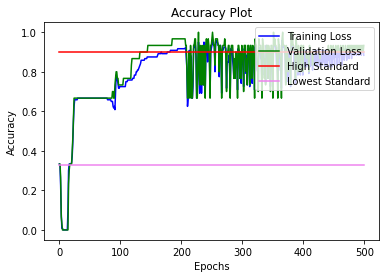

The training accuracy is: 88.3333
The validation accuracy is: 93.3333


In [11]:
mlp = Nueral_Network(init_algo='xavier',activation='tanh')
mlp.fit(X_train,Y_train_one_hot,display_loss=True,epochs=500,eta=0.1,beta=0.8,algo='GD')
print_accuracy()

#  with relu

parameters:  {'W1': array([[ 0.88202617,  0.2000786 ,  0.48936899,  1.1204466 ,  0.933779  ,
        -0.48863894,  0.47504421, -0.0756786 ],
       [-0.05160943,  0.20529925,  0.07202179,  0.72713675,  0.38051886,
         0.06083751,  0.22193162,  0.16683716],
       [ 0.74703954, -0.10257913,  0.15653385, -0.42704787, -1.27649491,
         0.3268093 ,  0.4322181 , -0.37108251],
       [ 1.13487731, -0.72718284,  0.02287926, -0.09359193,  0.76638961,
         0.73467938,  0.07747371,  0.18908126]]), 'B1': array([[-0.88778575, -1.98079647, -0.34791215,  0.15634897,  1.23029068,
         1.20237985, -0.38732682, -0.30230275]]), 'W2': array([[-0.37071946, -0.50205216, -0.60325761,  0.68970326, -0.18018926,
        -0.15488265, -0.44293005,  0.27488435],
       [-0.57059906, -0.07521505, -0.31659524,  0.13679069, -0.18059689,
        -0.41741651, -0.00996392,  0.15143819],
       [ 0.02351739,  0.10693997, -0.22426673, -0.12824837, -0.23775067,
        -0.12712124, -0.28749063, -0.6103330

<ipython-input-5-d46152a1b57e>:148: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs),unit="epoch",total=epochs):


  0%|          | 0/500 [00:00<?, ?epoch/s]

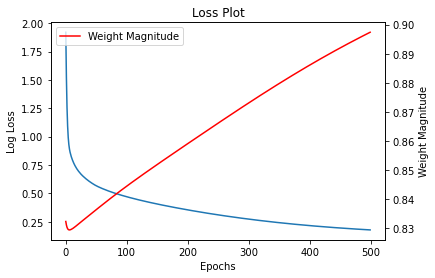

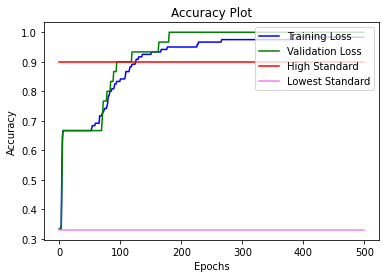

The training accuracy is: 98.3333
The validation accuracy is: 100.0


In [12]:
mlp = Nueral_Network(init_algo='xavier',activation='relu')
mlp.fit(X_train,Y_train_one_hot,display_loss=True,epochs=500,eta=0.01,beta=0.8,algo='GD')
print_accuracy()

parameters:  {'W1': array([[ 0.88202617,  0.2000786 ,  0.48936899,  1.1204466 ,  0.933779  ,
        -0.48863894,  0.47504421, -0.0756786 ],
       [-0.05160943,  0.20529925,  0.07202179,  0.72713675,  0.38051886,
         0.06083751,  0.22193162,  0.16683716],
       [ 0.74703954, -0.10257913,  0.15653385, -0.42704787, -1.27649491,
         0.3268093 ,  0.4322181 , -0.37108251],
       [ 1.13487731, -0.72718284,  0.02287926, -0.09359193,  0.76638961,
         0.73467938,  0.07747371,  0.18908126]]), 'B1': array([[-0.88778575, -1.98079647, -0.34791215,  0.15634897,  1.23029068,
         1.20237985, -0.38732682, -0.30230275]]), 'W2': array([[-0.37071946, -0.50205216, -0.60325761,  0.68970326, -0.18018926,
        -0.15488265, -0.44293005,  0.27488435],
       [-0.57059906, -0.07521505, -0.31659524,  0.13679069, -0.18059689,
        -0.41741651, -0.00996392,  0.15143819],
       [ 0.02351739,  0.10693997, -0.22426673, -0.12824837, -0.23775067,
        -0.12712124, -0.28749063, -0.6103330

<ipython-input-5-d46152a1b57e>:148: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs),unit="epoch",total=epochs):


  0%|          | 0/800 [00:00<?, ?epoch/s]

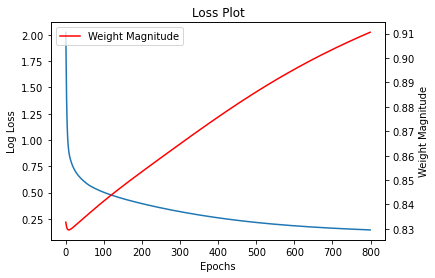

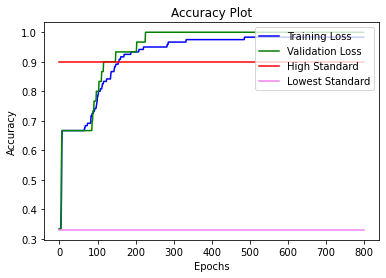

The training accuracy is: 98.3333
The validation accuracy is: 100.0


In [13]:
mlp = Nueral_Network(init_algo='xavier',activation='relu')
mlp.fit(X_train,Y_train_one_hot,display_loss=True,epochs=800,eta=0.008,beta=0.8,algo='GD')
print_accuracy()

parameters:  {'W1': array([[ 0.88202617,  0.2000786 ,  0.48936899,  1.1204466 ,  0.933779  ,
        -0.48863894,  0.47504421, -0.0756786 ],
       [-0.05160943,  0.20529925,  0.07202179,  0.72713675,  0.38051886,
         0.06083751,  0.22193162,  0.16683716],
       [ 0.74703954, -0.10257913,  0.15653385, -0.42704787, -1.27649491,
         0.3268093 ,  0.4322181 , -0.37108251],
       [ 1.13487731, -0.72718284,  0.02287926, -0.09359193,  0.76638961,
         0.73467938,  0.07747371,  0.18908126]]), 'B1': array([[-0.88778575, -1.98079647, -0.34791215,  0.15634897,  1.23029068,
         1.20237985, -0.38732682, -0.30230275]]), 'W2': array([[-0.37071946, -0.50205216, -0.60325761,  0.68970326, -0.18018926,
        -0.15488265, -0.44293005,  0.27488435],
       [-0.57059906, -0.07521505, -0.31659524,  0.13679069, -0.18059689,
        -0.41741651, -0.00996392,  0.15143819],
       [ 0.02351739,  0.10693997, -0.22426673, -0.12824837, -0.23775067,
        -0.12712124, -0.28749063, -0.6103330

<ipython-input-5-d46152a1b57e>:148: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs),unit="epoch",total=epochs):


  0%|          | 0/800 [00:00<?, ?epoch/s]

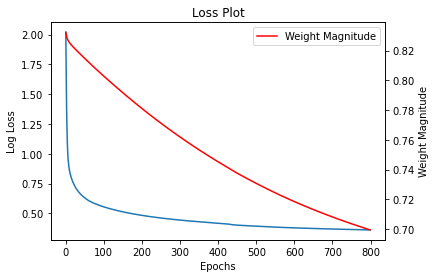

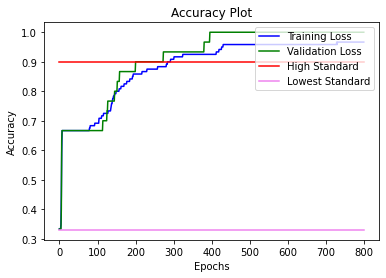

The training accuracy is: 96.6667
The validation accuracy is: 100.0


In [14]:
mlp = Nueral_Network(init_algo='xavier',activation='relu')
mlp.fit(X_train,Y_train_one_hot,display_loss=True,epochs=800,eta=0.008,beta=0.8,algo='GD',l2_norm=True,lambda_val=15)
print_accuracy()

parameters:  {'W1': array([[ 0.88202617,  0.2000786 ,  0.48936899,  1.1204466 ,  0.933779  ,
        -0.48863894,  0.47504421, -0.0756786 ],
       [-0.05160943,  0.20529925,  0.07202179,  0.72713675,  0.38051886,
         0.06083751,  0.22193162,  0.16683716],
       [ 0.74703954, -0.10257913,  0.15653385, -0.42704787, -1.27649491,
         0.3268093 ,  0.4322181 , -0.37108251],
       [ 1.13487731, -0.72718284,  0.02287926, -0.09359193,  0.76638961,
         0.73467938,  0.07747371,  0.18908126]]), 'B1': array([[-0.88778575, -1.98079647, -0.34791215,  0.15634897,  1.23029068,
         1.20237985, -0.38732682, -0.30230275]]), 'W2': array([[-0.37071946, -0.50205216, -0.60325761,  0.68970326, -0.18018926,
        -0.15488265, -0.44293005,  0.27488435],
       [-0.57059906, -0.07521505, -0.31659524,  0.13679069, -0.18059689,
        -0.41741651, -0.00996392,  0.15143819],
       [ 0.02351739,  0.10693997, -0.22426673, -0.12824837, -0.23775067,
        -0.12712124, -0.28749063, -0.6103330

<ipython-input-5-d46152a1b57e>:148: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs),unit="epoch",total=epochs):


  0%|          | 0/750 [00:00<?, ?epoch/s]

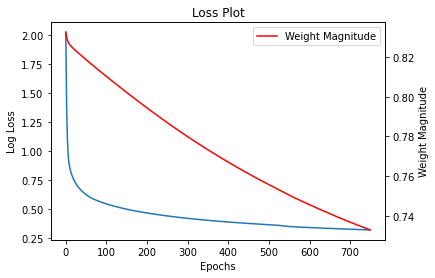

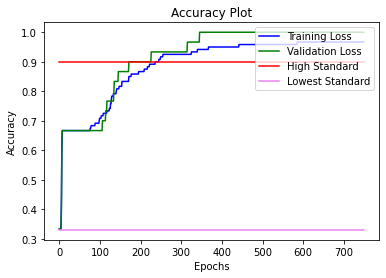

The training accuracy is: 96.6667
The validation accuracy is: 100.0


In [15]:
mlp = Nueral_Network(init_algo='xavier',activation='relu')
mlp.fit(X_train,Y_train_one_hot,display_loss=True,epochs=750,eta=0.008,beta=0.8,algo='GD',l2_norm=True,lambda_val=12)
print_accuracy()

parameters:  {'W1': array([[ 0.88202617,  0.2000786 ,  0.48936899,  1.1204466 ,  0.933779  ,
        -0.48863894,  0.47504421, -0.0756786 ],
       [-0.05160943,  0.20529925,  0.07202179,  0.72713675,  0.38051886,
         0.06083751,  0.22193162,  0.16683716],
       [ 0.74703954, -0.10257913,  0.15653385, -0.42704787, -1.27649491,
         0.3268093 ,  0.4322181 , -0.37108251],
       [ 1.13487731, -0.72718284,  0.02287926, -0.09359193,  0.76638961,
         0.73467938,  0.07747371,  0.18908126]]), 'B1': array([[-0.88778575, -1.98079647, -0.34791215,  0.15634897,  1.23029068,
         1.20237985, -0.38732682, -0.30230275]]), 'W2': array([[-0.37071946, -0.50205216, -0.60325761,  0.68970326, -0.18018926,
        -0.15488265, -0.44293005,  0.27488435],
       [-0.57059906, -0.07521505, -0.31659524,  0.13679069, -0.18059689,
        -0.41741651, -0.00996392,  0.15143819],
       [ 0.02351739,  0.10693997, -0.22426673, -0.12824837, -0.23775067,
        -0.12712124, -0.28749063, -0.6103330

<ipython-input-5-d46152a1b57e>:148: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs),unit="epoch",total=epochs):


  0%|          | 0/750 [00:00<?, ?epoch/s]

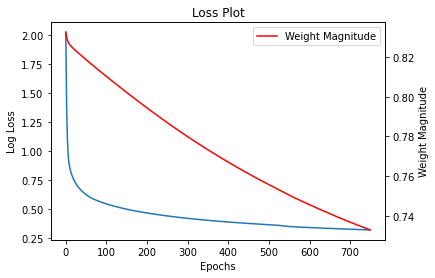

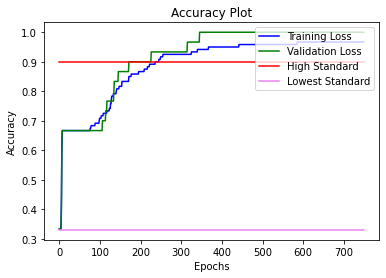

The training accuracy is: 96.6667
The validation accuracy is: 100.0


In [16]:
mlp = Nueral_Network(init_algo='xavier',activation='relu')
mlp.fit(X_train,Y_train_one_hot,display_loss=True,epochs=750,eta=0.008,beta=0.8,algo='GD',l2_norm=True,lambda_val=12)
print_accuracy()

## Early Stopping

parameters:  {'W1': array([[ 0.88202617,  0.2000786 ,  0.48936899,  1.1204466 ,  0.933779  ,
        -0.48863894,  0.47504421, -0.0756786 ],
       [-0.05160943,  0.20529925,  0.07202179,  0.72713675,  0.38051886,
         0.06083751,  0.22193162,  0.16683716],
       [ 0.74703954, -0.10257913,  0.15653385, -0.42704787, -1.27649491,
         0.3268093 ,  0.4322181 , -0.37108251],
       [ 1.13487731, -0.72718284,  0.02287926, -0.09359193,  0.76638961,
         0.73467938,  0.07747371,  0.18908126]]), 'B1': array([[-0.88778575, -1.98079647, -0.34791215,  0.15634897,  1.23029068,
         1.20237985, -0.38732682, -0.30230275]]), 'W2': array([[-0.37071946, -0.50205216, -0.60325761,  0.68970326, -0.18018926,
        -0.15488265, -0.44293005,  0.27488435],
       [-0.57059906, -0.07521505, -0.31659524,  0.13679069, -0.18059689,
        -0.41741651, -0.00996392,  0.15143819],
       [ 0.02351739,  0.10693997, -0.22426673, -0.12824837, -0.23775067,
        -0.12712124, -0.28749063, -0.6103330

<ipython-input-5-d46152a1b57e>:148: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs),unit="epoch",total=epochs):


  0%|          | 0/500 [00:00<?, ?epoch/s]

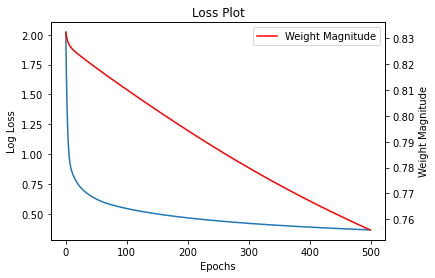

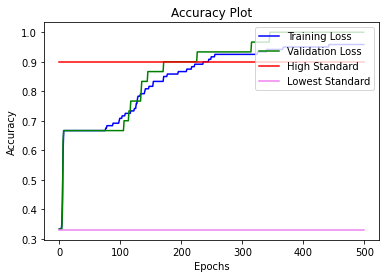

The training accuracy is: 95.8333
The validation accuracy is: 100.0


In [17]:
mlp = Nueral_Network(init_algo='xavier',activation='relu')
mlp.fit(X_train,Y_train_one_hot,display_loss=True,epochs=500,eta=0.008,beta=0.8,algo='GD',l2_norm=True,lambda_val=12)
print_accuracy()

# He with Relu

parameters:  {'W1': array([[ 1.24737338,  0.28295388,  0.69207227,  1.58455078,  1.32056292,
        -0.69103982,  0.67181396, -0.10702571],
       [-0.07298675,  0.29033699,  0.10185419,  1.02832666,  0.53813494,
         0.08603723,  0.3138587 ,  0.23594338],
       [ 1.05647344, -0.1450688 ,  0.22137229, -0.60393689, -1.80523641,
         0.46217814,  0.6112487 , -0.52478992],
       [ 1.60495889, -1.02839183,  0.03235616, -0.13235897,  1.08383858,
         1.03899355,  0.10956438,  0.26740128]]), 'B1': array([[-0.88778575, -1.98079647, -0.34791215,  0.15634897,  1.23029068,
         1.20237985, -0.38732682, -0.30230275]]), 'W2': array([[-0.52427648, -0.71000897, -0.8531351 ,  0.9753877 , -0.25482609,
        -0.21903715, -0.62639768,  0.38874518],
       [-0.80694892, -0.10637014, -0.44773328,  0.19345125, -0.25540257,
        -0.59031609, -0.01409111,  0.21416594],
       [ 0.03325861,  0.15123595, -0.31716105, -0.18137058, -0.33623022,
        -0.17977658, -0.40657314, -0.8631413

<ipython-input-5-d46152a1b57e>:148: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs),unit="epoch",total=epochs):


  0%|          | 0/700 [00:00<?, ?epoch/s]

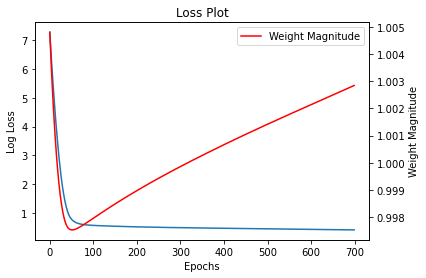

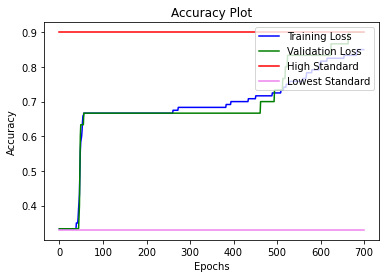

The training accuracy is: 85.0
The validation accuracy is: 90.0


In [18]:
mlp = Nueral_Network(init_algo='he',activation='relu')
mlp.fit(X_train,Y_train_one_hot,display_loss=True,epochs=700,eta=0.001,beta=0.8,algo='GD')
print_accuracy()

# Xavier with sigmoid

parameters:  {'W1': array([[ 0.88202617,  0.2000786 ,  0.48936899,  1.1204466 ,  0.933779  ,
        -0.48863894,  0.47504421, -0.0756786 ],
       [-0.05160943,  0.20529925,  0.07202179,  0.72713675,  0.38051886,
         0.06083751,  0.22193162,  0.16683716],
       [ 0.74703954, -0.10257913,  0.15653385, -0.42704787, -1.27649491,
         0.3268093 ,  0.4322181 , -0.37108251],
       [ 1.13487731, -0.72718284,  0.02287926, -0.09359193,  0.76638961,
         0.73467938,  0.07747371,  0.18908126]]), 'B1': array([[-0.88778575, -1.98079647, -0.34791215,  0.15634897,  1.23029068,
         1.20237985, -0.38732682, -0.30230275]]), 'W2': array([[-0.37071946, -0.50205216, -0.60325761,  0.68970326, -0.18018926,
        -0.15488265, -0.44293005,  0.27488435],
       [-0.57059906, -0.07521505, -0.31659524,  0.13679069, -0.18059689,
        -0.41741651, -0.00996392,  0.15143819],
       [ 0.02351739,  0.10693997, -0.22426673, -0.12824837, -0.23775067,
        -0.12712124, -0.28749063, -0.6103330

<ipython-input-5-d46152a1b57e>:148: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs),unit="epoch",total=epochs):


  0%|          | 0/400 [00:00<?, ?epoch/s]

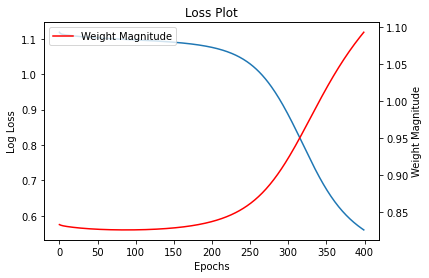

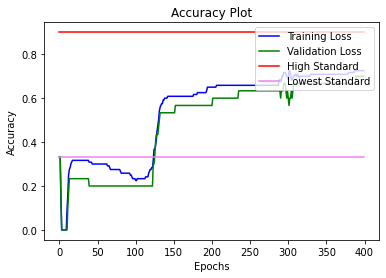

The training accuracy is: 72.5
The validation accuracy is: 70.0


In [19]:
mlp = Nueral_Network(init_algo='xavier',activation='sigmoid')
mlp.fit(X_train,Y_train_one_hot,display_loss=True,epochs=400,eta=0.2,beta=0.8,algo='GD')
print_accuracy()

# Xavier with tanh

parameters:  {'W1': array([[ 0.88202617,  0.2000786 ,  0.48936899,  1.1204466 ,  0.933779  ,
        -0.48863894,  0.47504421, -0.0756786 ],
       [-0.05160943,  0.20529925,  0.07202179,  0.72713675,  0.38051886,
         0.06083751,  0.22193162,  0.16683716],
       [ 0.74703954, -0.10257913,  0.15653385, -0.42704787, -1.27649491,
         0.3268093 ,  0.4322181 , -0.37108251],
       [ 1.13487731, -0.72718284,  0.02287926, -0.09359193,  0.76638961,
         0.73467938,  0.07747371,  0.18908126]]), 'B1': array([[-0.88778575, -1.98079647, -0.34791215,  0.15634897,  1.23029068,
         1.20237985, -0.38732682, -0.30230275]]), 'W2': array([[-0.37071946, -0.50205216, -0.60325761,  0.68970326, -0.18018926,
        -0.15488265, -0.44293005,  0.27488435, -0.57059906, -0.07521505,
        -0.31659524,  0.13679069, -0.18059689, -0.41741651, -0.00996392,
         0.15143819],
       [ 0.02351739,  0.10693997, -0.22426673, -0.12824837, -0.23775067,
        -0.12712124, -0.28749063, -0.61033307

<ipython-input-5-d46152a1b57e>:148: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs),unit="epoch",total=epochs):


  0%|          | 0/150 [00:00<?, ?epoch/s]

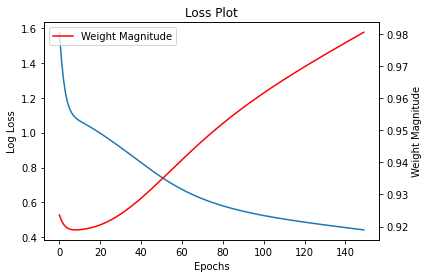

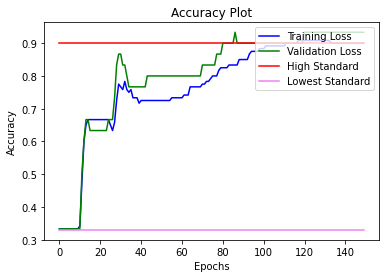

The training accuracy is: 90.0
The validation accuracy is: 93.3333


In [20]:
mlp = Nueral_Network(init_algo='xavier',activation='tanh',num_nu1=8,num_nu2=16)
mlp.fit(X_train,Y_train_one_hot,display_loss=True,epochs=150,eta=0.05,beta=0.8,algo='GD')
print_accuracy()

# He with ReLU

parameters:  {'W1': array([[ 1.24737338,  0.28295388,  0.69207227,  1.58455078,  1.32056292,
        -0.69103982,  0.67181396, -0.10702571],
       [-0.07298675,  0.29033699,  0.10185419,  1.02832666,  0.53813494,
         0.08603723,  0.3138587 ,  0.23594338],
       [ 1.05647344, -0.1450688 ,  0.22137229, -0.60393689, -1.80523641,
         0.46217814,  0.6112487 , -0.52478992],
       [ 1.60495889, -1.02839183,  0.03235616, -0.13235897,  1.08383858,
         1.03899355,  0.10956438,  0.26740128]]), 'B1': array([[-0.88778575, -1.98079647, -0.34791215,  0.15634897,  1.23029068,
         1.20237985, -0.38732682, -0.30230275]]), 'W2': array([[-0.52427648, -0.71000897, -0.8531351 ,  0.9753877 , -0.25482609,
        -0.21903715, -0.62639768,  0.38874518, -0.80694892, -0.10637014,
        -0.44773328,  0.19345125, -0.25540257, -0.59031609, -0.01409111,
         0.21416594],
       [ 0.03325861,  0.15123595, -0.31716105, -0.18137058, -0.33623022,
        -0.17977658, -0.40657314, -0.8631413 

<ipython-input-5-d46152a1b57e>:148: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs),unit="epoch",total=epochs):


  0%|          | 0/200 [00:00<?, ?epoch/s]

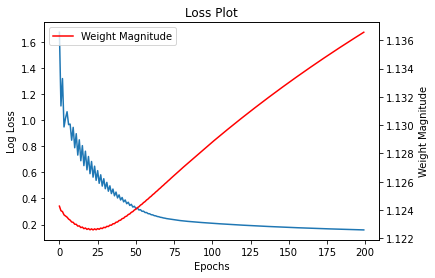

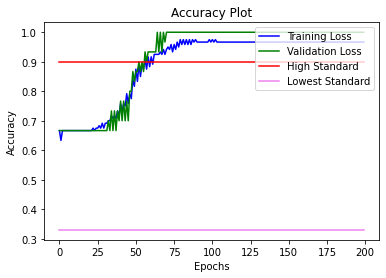

The training accuracy is: 96.6667
The validation accuracy is: 100.0


In [21]:
mlp = Nueral_Network(init_algo='he',activation='relu',num_nu1=8,num_nu2=16)
mlp.fit(X_train,Y_train_one_hot,display_loss=True,epochs=200,eta=0.01,beta=0.8,algo='GD')
print_accuracy()

# He with Leaky Relu

parameters:  {'W1': array([[ 1.24737338,  0.28295388,  0.69207227,  1.58455078,  1.32056292,
        -0.69103982,  0.67181396, -0.10702571, -0.07298675,  0.29033699,
         0.10185419,  1.02832666,  0.53813494,  0.08603723,  0.3138587 ,
         0.23594338],
       [ 1.05647344, -0.1450688 ,  0.22137229, -0.60393689, -1.80523641,
         0.46217814,  0.6112487 , -0.52478992,  1.60495889, -1.02839183,
         0.03235616, -0.13235897,  1.08383858,  1.03899355,  0.10956438,
         0.26740128],
       [-0.62775932, -1.40063461, -0.24601104,  0.11055542,  0.86994688,
         0.85021094, -0.27388142, -0.21376032, -0.74143891, -1.00410431,
        -1.20651522,  1.37940651, -0.36037851, -0.30976531, -0.88586009,
         0.5497687 ],
       [-1.14119811, -0.15043009, -0.63319048,  0.27358138, -0.36119378,
        -0.83483302, -0.01992784,  0.30287637,  0.04703478,  0.21387993,
        -0.44853345, -0.25649674, -0.47550134, -0.25424248, -0.57498125,
        -1.22066613]]), 'B1': array([[

<ipython-input-5-d46152a1b57e>:148: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs),unit="epoch",total=epochs):


  0%|          | 0/2200 [00:00<?, ?epoch/s]

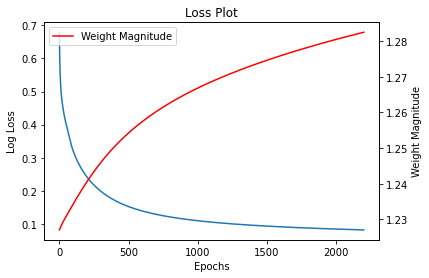

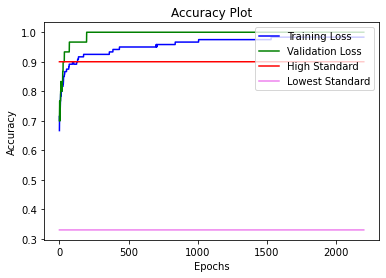

The training accuracy is: 98.3333
The validation accuracy is: 100.0


In [22]:
mlp = Nueral_Network(init_algo='he',activation='leaky relu',num_nu1=16,num_nu2=16)
mlp.fit(X_train,Y_train_one_hot,display_loss=True,epochs=2200,eta=0.01,beta=0.8,algo='GD')
print_accuracy()